# **Exercise 2.** C. Soneira

## Question. **Using the tools for function optimization seen in the course, find a solution for the following inquiries.**
1. **Plot the data (including error bars, assuming Poisson statistics), rebin them in weekly number of cases**
2. **Concentrating on t=650 to 740 days after 1 January 2020, and defining** $t'(t_{0} )=\max(0,t-t_{0} )$:
    - a. Model the evolution of daily cases as a constant plus a power evolution in t'. First assume a constant (a=0), then a constant plus a single power with a=1, then a single power with a=2, then a combination of two powerlaws with a=1 and b=2 and with different values of t0, and finally a combination with free exponents.
    - b. Make sure to answer the following two questions in your report:
        - Which of them is the best model? Why?
        - When did the corresponding wave start? Why?
    - c. Optional for extra score: plot Δχ 2 contours on (a,b) for the model with free exponents. What can you conclude from them?

## **Introduction**
We are going to use the R usual functions to manipulate the data, creating functions and plotting. The only *special function* we are using is `optim`, which, given a scalar function and a set of initial parameters returns the value of those parameters that make the function reach a minimum. The syntax is `optim(parameter vector, function to minimize, xdata, ydata)`. As a remark, this function, at least in its default options, requires quite precise initial parameters to work properly.

### Non linear fitting *by hand*
There are some functions which R provides that allow to fit a set of data to a certain function given some parameters, but we are doing something which is more *from scratch*: we are defining the $\chi^{2}$ statistic and trying to minimize it with the `optim` function. This is interesting for didactic purposes because this is how most more elaborate functions actually work, but also because it allows us to be more flexible in the definition of the function that defines *the goodness of the fit*.

## **Results**

### 1. Plot the data (including error bars, assuming Poisson statistics), rebin them in weekly number of cases

We import the data and the libraries we are using, in this case Hmisc is useful for errorbar plots.

In [2]:
library(Hmisc)

dat <- read.csv("isciii_Cantabria_code01.csv")
# head(dat)

We plot the data.

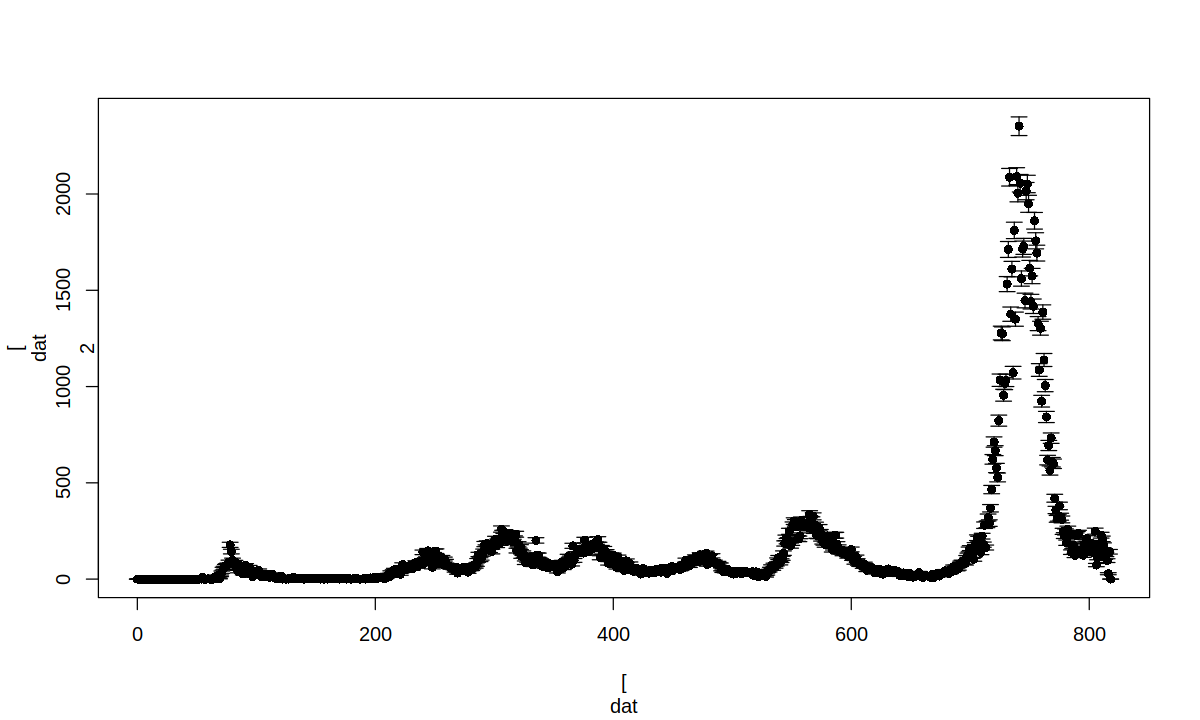

In [3]:
options(repr.plot.width=10,repr.plot.height=6)
errbar(dat[,1],dat[,2],dat[,2]+sqrt(dat[,2]),dat[,2]-sqrt(dat[,2]))

We rebin in 7 days blocks (0-6, 7-13, ...)

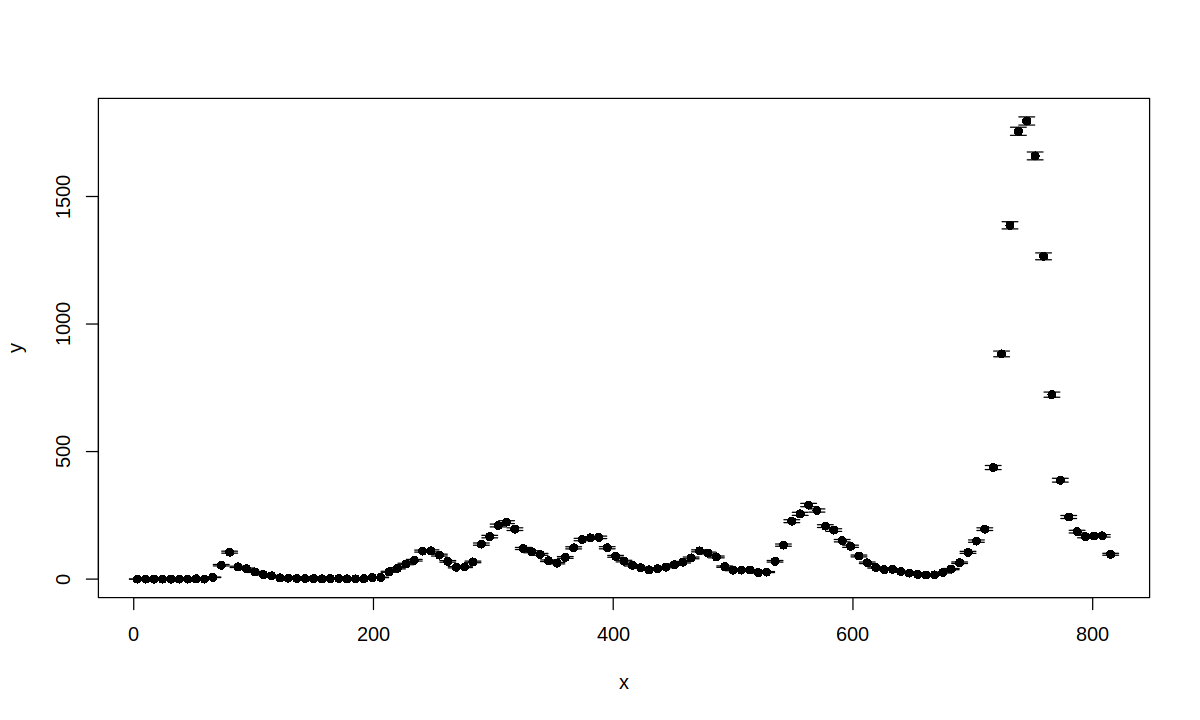

In [4]:
x <- c()
y <- c()
sdy <- c()
n <- length(dat[,2])

for (i in seq(1,n,by=7)){
    # cat("i=",i,"\n")
    # cat(sum(dat[,2][i-1:i+7]),"\n")
    j <- i+6
    y <- c(y,sum(dat[,2][i:j])/7)
    # Assuming Poisson in the number of cases per day, the deviation is the sqrt of the values
    sdy <- c(sdy, sqrt( sum( dat[,2][i:j] ) )/7 )
    x <- c(x,i+2)
}

errbar(x,y,y+sdy,y-sdy)

### 2. Concentrating on t=650 to 740 days after 1 January 2020, and defining $t'(t_{0} )=\max(0,t-t_{0} )$:
- a. Model the evolution of daily cases as a constant plus a power evolution in t'. First assume a constant (a=0), then a constant plus a single power with a=1, then a single power with a=2, then a combination of two powerlaws with a=1 and b=2 and with different values of t0, and finally a combination with free exponents.

We plot binned interval from 650 to 740 days

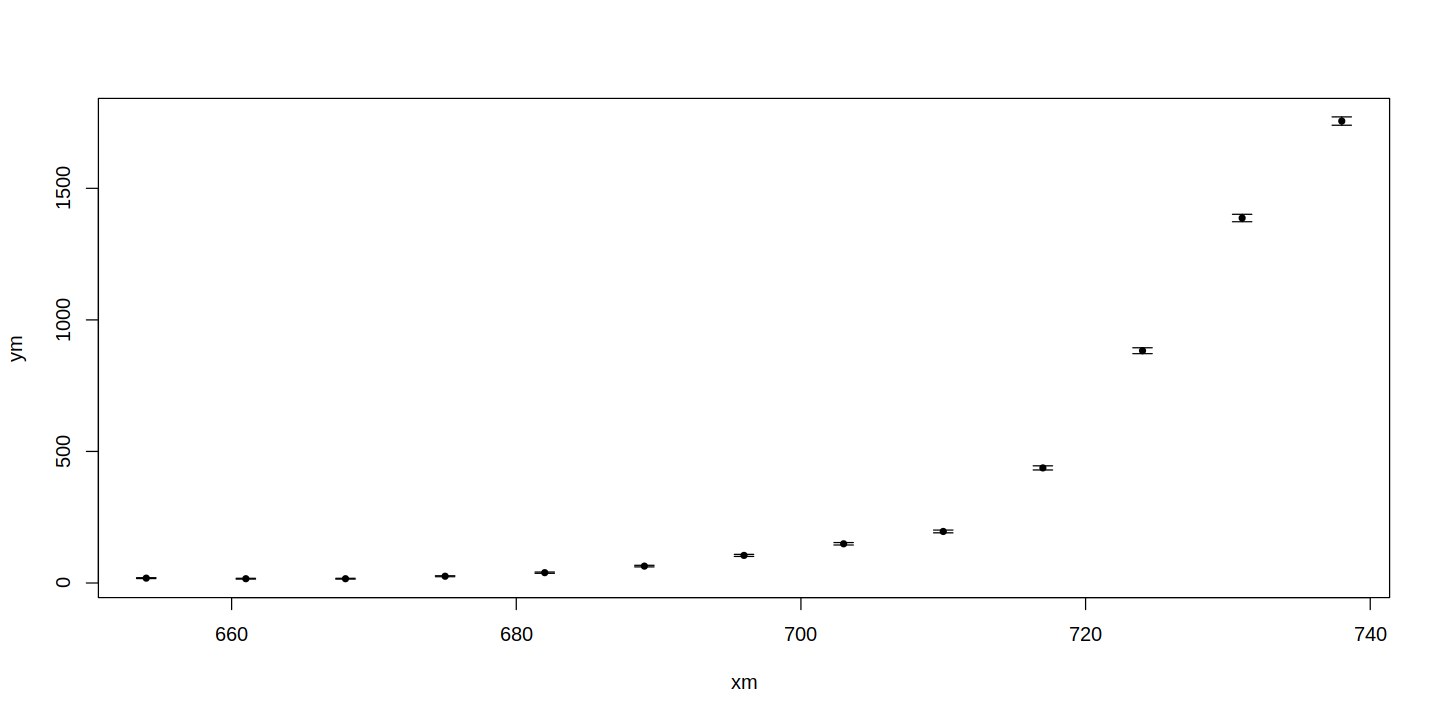

In [5]:
options(repr.plot.width=12,repr.plot.height=6)

xm <- x[x>650 & x<740]
ym <- y[x>650 & x<740]
sdym <- sdy[x>650 & x<740]

write(cbind(x,y), "xy.txt")
errbar(xm, ym, ym+sdym, ym-sdym, type='p', pch=20)

### *Co (constant)* (1 parameter) $$N_{0}$$

 N0 =  45.92545 
Chisq =  31471.78 , pvalue =  0 


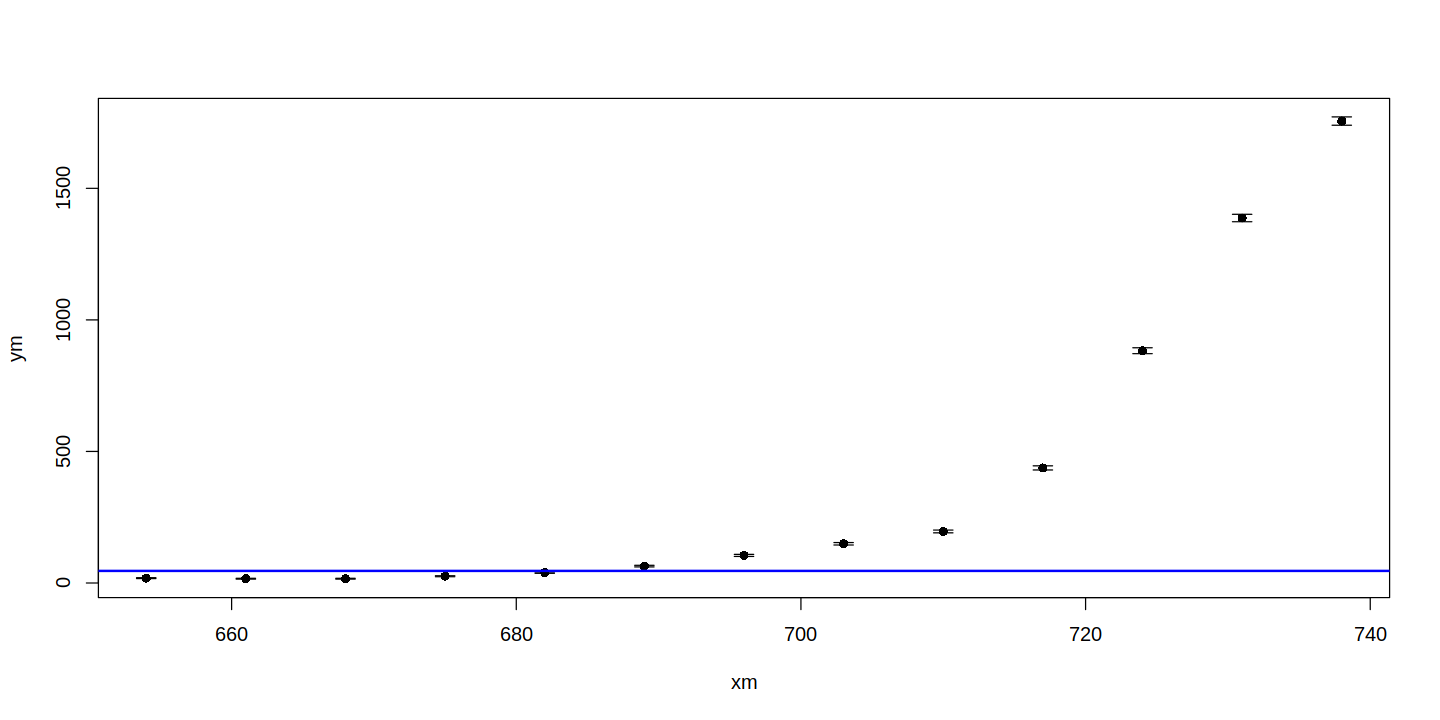

In [6]:
fit_lm <- lm(ym ~ 1, weights=1/sdym**2)
inter <- fit_lm$coef

errbar(xm, ym, ym+sdym, ym-sdym)
abline(fit_lm, col="blue", lwd=2)

cat(" N0 = ",inter,"\n")

# We get the chisq and the degrees of freedom
chi_co <- sum((ym-inter)**2/sdym**2)
cat("Chisq = ",chi_co, ", pvalue = ", 1-pchisq(chi_co,13-1),"\n")

d_co = length(ym) - 1

### *Coli* (3 parameters) $$N_0 + \frac{max(0,(x-t_0))}{\tau}$$ 

 N0 =  31.15459 ,
 t01 =  707.6493 , tau1 =  0.01832071 
Chisq =  1691.083 , pvalue =  0 


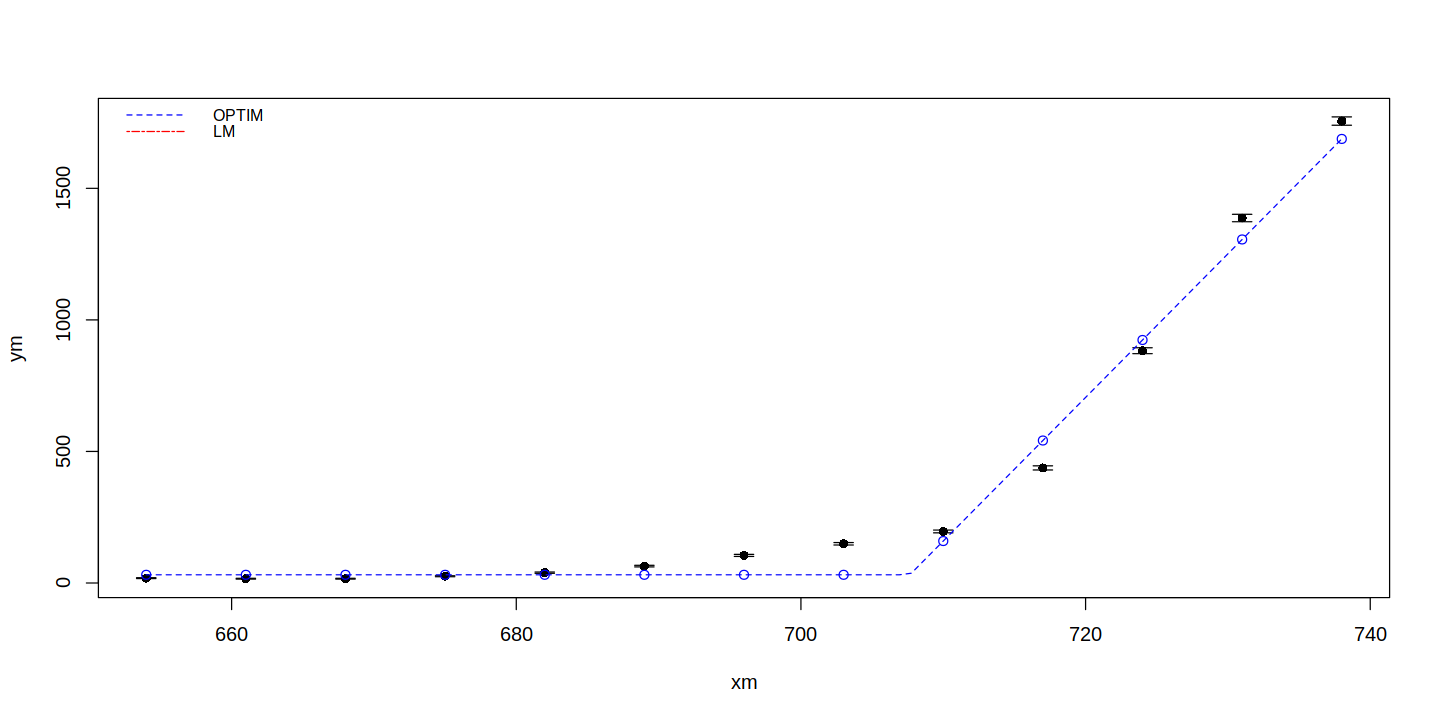

In [7]:
# N0 obtained for the previous fit
n00 <- inter/2
t00 <- 700
tau0 <- 0.01

ran = 1:100

for (i in ran){
        fun.to.fit <- function(x, n0, t0, tau){
        n0 + ifelse((x-t0)<0,0,x-t0)/tau
    }

    fun.to.minimize <- function(coefs,x,y){
        n0 <- coefs[1]
        t0 <- coefs[2]
        tau <- coefs[3]
        out <- sum( (y-fun.to.fit(x,n0, t0, tau))**2/sdym**2 )
    }
        
        fit_optim <- optim(c(n00,t00,tau0), fun.to.minimize, x=xm, y=ym)

        afit <- fit_optim$par[1]
        bfit <- fit_optim$par[2]
        cfit <- fit_optim$par[3]
        
        n00 <- afit
        t010 <- bfit
        tau10 <- cfit
}
  
cat(" N0 = ",afit,",\n t01 = ",bfit,", tau1 = ",cfit,"\n")

# We get the chisq and the degrees of freedom
chi_coli <- sum((ym-fun.to.fit(xm,afit,bfit,cfit))**2/sdym**2)
cat("Chisq = ",chi_coli, ", pvalue = ", 1-pchisq(chi_coli,13-3),"\n")
d_coli <- length(ym) - 3

errbar(xm, ym, ym+sdym, ym-sdym)
points(xm,fun.to.fit(xm,afit,bfit,cfit), col='blue',lty=2)
curve(fun.to.fit(x,afit,bfit,cfit), add = TRUE, col='blue',lty=2)
legend("topleft", c("OPTIM", "LM"), lty=c(2,6), col=c("blue","red"), cex=0.8, bty='n')

### *Coliqua* (5 parameters) $$N_0 + \frac{max(0,(x-t_{01}))}{\tau_1} + \left(\frac{max(0,(x-t_{02}))}{\tau_2}\right)^2$$ 

 N0 =  16.91745 ,
 t01 =  713.5929 , tau1 =  0.01889711 ,
 t02 =  666.1163 , tau2 =  3.25108 
Chisq =  24.93416 , pvalue =  0.001595 


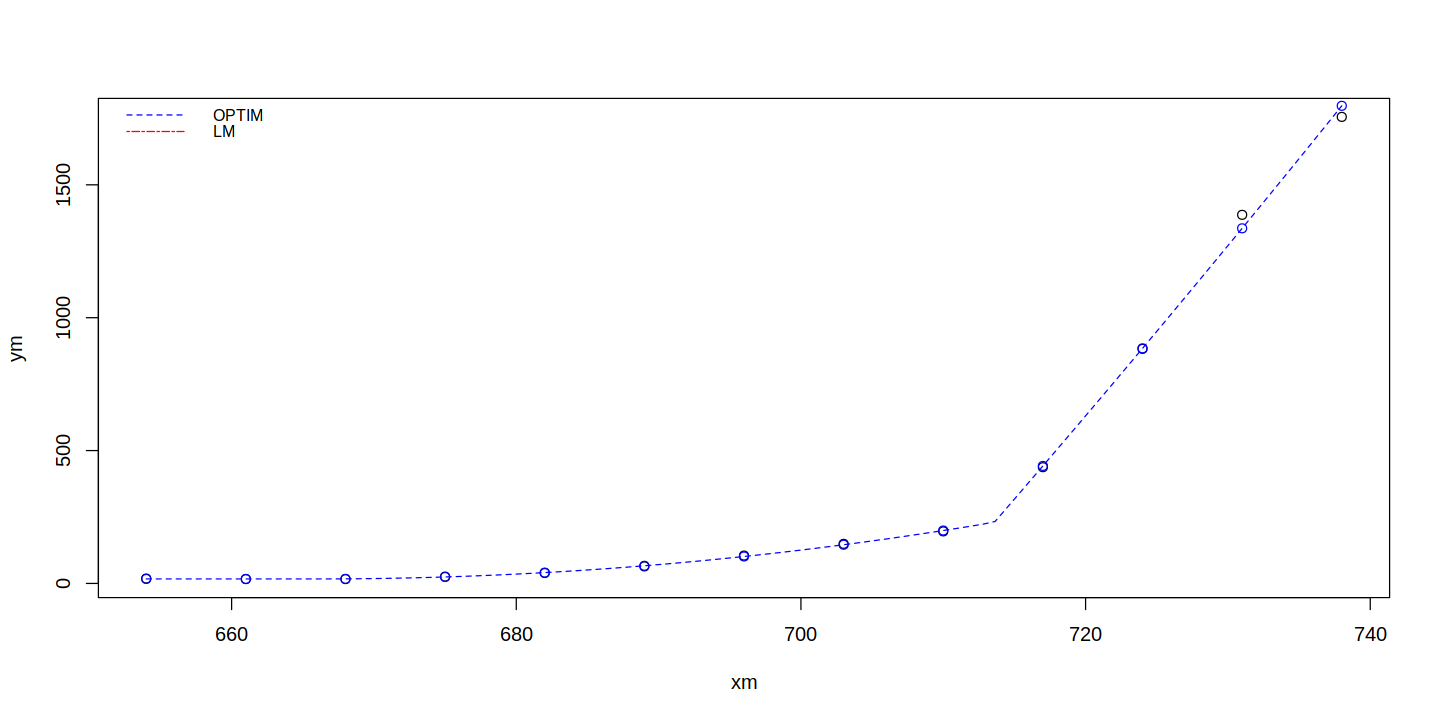

In [8]:
# N0 obtained for the previous fit
n00 <- 50
t010 <- 713 # Very sensitive to this value
tau10 <- 0.018
t020 <- 680
tau20 <- 3.1

ran <- 1:100

for (i in ran){
        fun.to.fit <- function(x, n0, t01, tau1, t02, tau2){
        n0 + ifelse((x-t01)<0,0,x-t01)/tau1 + (ifelse((x-t02)<0,0,x-t02)/tau2)**2
        # y <- n0 + replace(x, x-t0 < 0, 0)/tau
        # return(y)
    }

    fun.to.minimize <- function(coefs,x,y){
        n0 <- coefs[1]
        t01 <- coefs[2]
        tau1 <- coefs[3]
        t02 <- coefs[4]
        tau2 <- coefs[5]

        out <- sum((y-fun.to.fit(x,n0, t01,tau1, t02, tau2))**2/sdym**2)
    }
        
        fit_optim <- optim(c(n00,t010,tau10,t020,tau20), fun.to.minimize, x=xm, y=ym)

        afit <- fit_optim$par[1]
        bfit <- fit_optim$par[2]
        cfit <- fit_optim$par[3]
        dfit <- fit_optim$par[4]
        efit <- fit_optim$par[5]
        
        n00 <- afit
        t010 <- bfit
        tau10 <- cfit
        t020 <- dfit
        tau20 <- efit
}

cat(" N0 = ",afit,",\n t01 = ",bfit,", tau1 = ",cfit,",\n t02 = ",dfit, ", tau2 = ",efit,"\n")

# We get the chisq and the degrees of freedom
chi_coliqua <- sum((ym-fun.to.fit(xm,afit,bfit,cfit,dfit,efit))**2/sdym**2)
cat("Chisq = ",chi_coliqua, ", pvalue = ", 1-pchisq(chi_coliqua,13-5),"\n")
d_coliqua <- length(ym) - 5

plot(xm,ym)
points(xm,fun.to.fit(xm,afit,bfit,cfit,dfit,efit), col='blue',lty=2)
curve(fun.to.fit(x,afit,bfit,cfit,dfit,efit), add = TRUE, col='blue',lty=2)
legend("topleft", c("OPTIM", "LM"), lty=c(2,6), col=c("blue","red"), cex=0.8, bty='n')

### *Cocopo* (7 parameters) $$ N_0 + \left(\frac{max(0,(x-t_{01})}{\tau_1}\right)^a + \left(\frac{max(0,(x-t_{02}))}{\tau_2}\right)^b $$

 N0 =  16.98646 ,
 t01 =  714.4404 , tau1 =  0.008112844 ,
 t02 =  666.6434 , tau2 =  3.059082 ,
 a =  0.8971624 , b =  1.962807 
Chisq =  18.95822 , pvalue =  0.00423477 


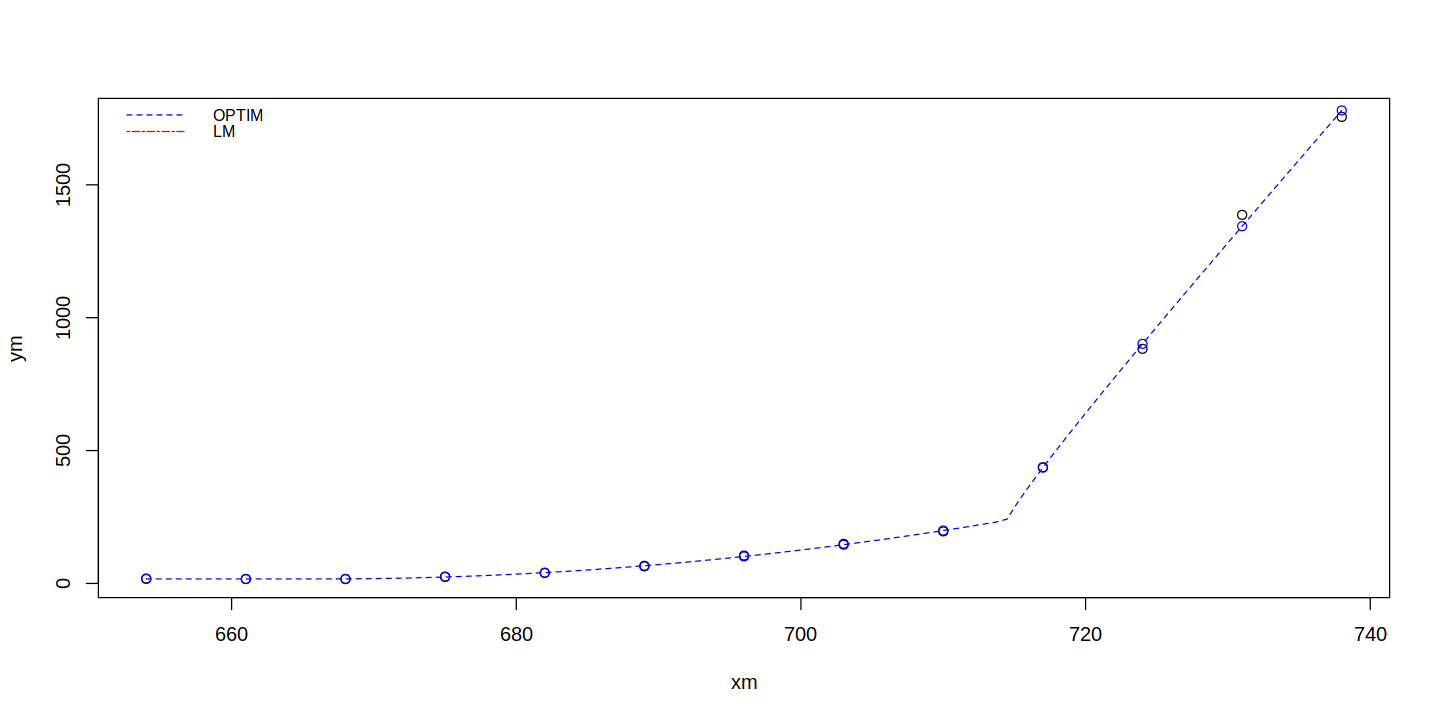

In [9]:
# N0 obtained for the previous fit
n00 <- 17
t010 <- 713 # Very sensitive to this value
tau10 <- 0.017
t020 <- 670
tau20 <- 3.1
a0 <- 1.01
b0 <- 2

ran <- 1:100

for (i in ran){
        fun.to.fit <- function(x, n0, t01, tau1, t02, tau2, a, b){
        n0 + (ifelse((x-t01)<0,0,x-t01)/tau1)**a + (ifelse((x-t02)<0,0,x-t02)/tau2)**b
    }

    fun.to.minimize <- function(coefs,x,y){
        n0 <- coefs[1]
        t01 <- coefs[2]
        tau1 <- coefs[3]
        t02 <- coefs[4]
        tau2 <- coefs[5]
        a <- coefs[6]
        b <- coefs[7]

        out <- sum((y-fun.to.fit(x, n0, t01, tau1, t02, tau2, a, b))**2/sdym**2)
    }
        
        fit_optim <- optim(c(n00,t010,tau10,t020,tau20, a0, b0), fun.to.minimize, x=xm, y=ym)

        afit <- fit_optim$par[1]
        bfit <- fit_optim$par[2]
        cfit <- fit_optim$par[3]
        dfit <- fit_optim$par[4]
        efit <- fit_optim$par[5]
        ffit <- fit_optim$par[6]
        gfit <- fit_optim$par[7]
        
        n00 <- afit
        t010 <- bfit
        tau10 <- cfit
        t020 <- dfit
        tau20 <- efit
        a0 <- ffit
        b0 <- gfit
}

cat(" N0 = ",afit,",\n t01 = ",bfit,", tau1 = ",cfit,",\n t02 = ",dfit, ", tau2 = ",efit, ",\n a = ", ffit,", b = ",gfit,"\n")

# We get the chisq and the degrees of freedom
chi_cocopo <- sum((ym-fun.to.fit(xm,afit,bfit,cfit,dfit,efit,ffit,gfit))**2/sdym**2)
cat("Chisq = ",chi_cocopo, ", pvalue = ", 1-pchisq(chi_cocopo,13-7),"\n")
d_cocopo <- length(ym) - 7

plot(xm,ym)
points(xm,fun.to.fit(xm,afit,bfit,cfit,dfit,efit,ffit,gfit), col='blue',lty=2)
curve(fun.to.fit(x,afit,bfit,cfit,dfit,efit,ffit,gfit), add = TRUE, col='blue',lty=2)
legend("topleft", c("OPTIM", "LM"), lty=c(2,6), col=c("blue","red"), cex=0.8, bty='n')

### 2. Concentrating on t=650 to 740 days after 1 January 2020, and defining $t'(t_{0} )=\max(0,t-t_{0} )$:
- b. Make sure to answer the following two questions in your report:
    - Which of them is the best model? Why?
    - When did the corresponding wave start? Why?

To select the best model we are using an F test. We know that a model with a number big enough of parameters will always fit the data (in the limit case we could use an interpolation), but sometimes complicating the fit function can not be worth it with the improvement we are obtaining when we compare with the data. To do the F test, then, we define a function to calculate the F value:

In [10]:
Ft <- function(chi1,d1,chi2,d2){
    F <- (chi1-chi2)/(d1-d2)*(d2)/(chi2)
    return(F)
}

**"co" vs "coli"**

In [11]:
F1 <- Ft(chi_co,d_co,chi_coli,d_coli)
pf(F1,d_co-d_coli,d_coli)

[1] 0.9999996

**"coli" vs "coliqua"**

In [12]:
F2 <- Ft(chi_coli,d_coli,chi_coliqua,d_coliqua)
pf(F2,d_coli-d_coliqua,d_coliqua)

[1] 1

**"coliqua" vs "copopo"**

In [13]:
F3 <- Ft(chi_coliqua,d_coliqua,chi_cocopo,d_cocopo)
pf(F3,d_coliqua-d_cocopo,d_cocopo)

[1] 0.5604493

According to this numbers, we can say:
- The probability for the coli (linear) model improving co (constant) is almost 1: it is definitely worth it to add these new parameters to the model. This is clear also because of the extremely high value of the $\chi^{2}$ for the co model: $\approx$30000, which is much bigger than the $\approx$1700 of the coli model.
- The probability for the coliqua (parabolic) model to improve the coliqua (linear) is, again, almost 1. It is one more time worth it to add those parameters.
- The probability for the cocopo (free exponents) to improve the coliqua (parabolic) is $\approx$0.56, which is not big enough to justify adding new parameters. The $\chi^{2}$ is improved only from 25 to 19, which does not suggest at all that the model is much better.

For these reasons, we conclude that **the best model between co, coli, coliqua and cocopo is coliqua (5 parameters)**. This means we should take the values suggested by this model as the best estimations for the parameters. The wave started, then, according to the coliqua model, between the day 667 and the 714, our best $t_{1}$ and $t_{2}$.

### 2. Concentrating on t=650 to 740 days after 1 January 2020, and defining $t'(t_{0} )=\max(0,t-t_{0} )$:
- c. Optional for extra score: plot Δχ 2 contours on (a,b) for the model with free exponents. What can you conclude from them?

In [14]:
ch <- c()

arange <- seq(0.7,1.1,by=0.02)
brange <- seq(1.4,2.8,by=0.02)

n00 <- 17
t010 <- 714 # Very sensitive to this value
tau10 <- 0.008
t020 <- 667
tau20 <- 3.06

start_time <- Sys.time()

for (a in arange){
    for (b in brange){
        
        ran <- 1:10

        for (i in ran){
                fun.to.fit <- function(x, n0, t01, tau1, t02, tau2){
                n0 + (ifelse(x-t01<0,0,x-t01)/tau1)**a + (ifelse(x-t02<0,0,x-t02)/tau2)**b
            }

            fun.to.minimize <- function(coefs,x,y){
                n0 <- coefs[1]
                t01 <- coefs[2]
                tau1 <- coefs[3]
                t02 <- coefs[4]
                tau2 <- coefs[5]

                out <- sum((y-fun.to.fit(x,n0, t01,tau1, t02, tau2))**2/sdym**2)
            }

                fit_optim <- optim(c(n00,t010,tau10,t020,tau20), fun.to.minimize, x=xm, y=ym)

                afit <- fit_optim$par[1]
                bfit <- fit_optim$par[2]
                cfit <- fit_optim$par[3]
                dfit <- fit_optim$par[4]
                efit <- fit_optim$par[5]

                n00 <- afit
                t010 <- bfit
                tau10 <- cfit
                t020 <- dfit
                tau20 <- efit
        }
        
        ch <- c(ch,sum((ym-fun.to.fit(xm,afit,bfit,cfit,dfit,efit))**2/sdym**2))
        }
}

end_time <- Sys.time()
print(end_time-start_time)

Time difference of 1.345268 mins


In [15]:
chnew <- matrix(ch, length(arange), length(brange),byrow=TRUE)

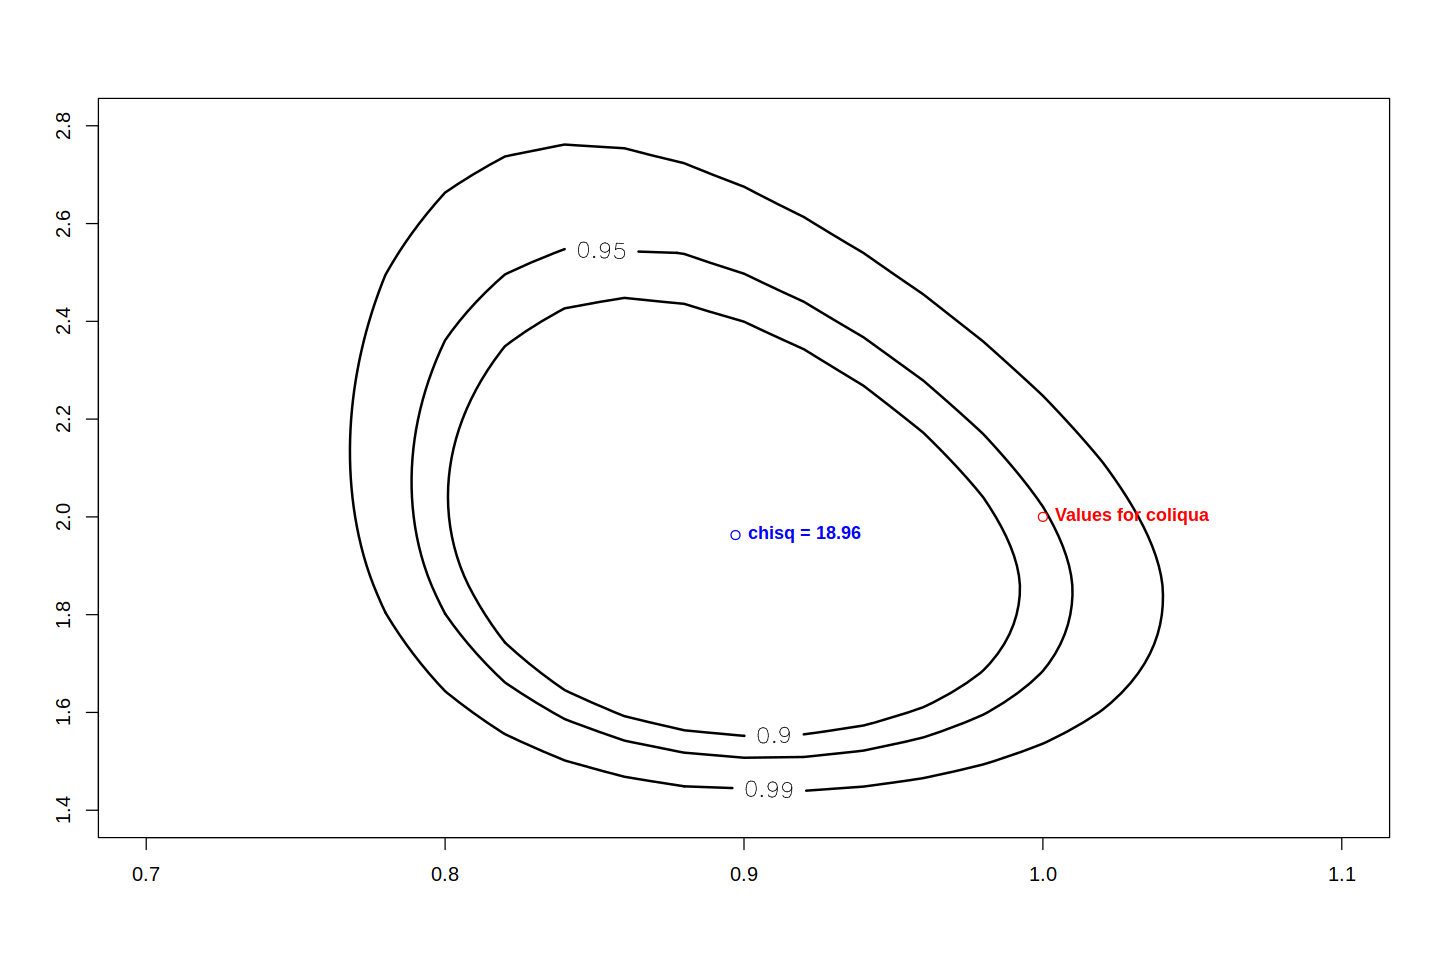

In [16]:
options(repr.plot.width=12,repr.plot.height=8)

contour(arange,brange,chnew,
        levels = c(18.95822+4.61,18.95822+6.17,18.95822+9.21),
        labcex = 1.2, labels = c(0.90,0.95,0.99),
        lwd = 2, lty = 1)
points(ffit, gfit,col = "blue")
text(ffit, gfit, labels="chisq = 18.96", col = "blue",cex=0.9, font=2, pos=4)
points(1, 2,col = "red")
text(1, 2, labels="Values for coliqua", col = "red",cex=0.9, font=2, pos=4)

### In conclusion:
From this last analysis we can conclude that the values that we used for the exponents in the coliqua model, 1 and 2, $N_0 + \frac{max(0,(x-t_{01}))}{\tau_1} + \left(\frac{max(0,(x-t_{02}))}{\tau_2}\right)^2$ are in the 95\% confidence interval for the best estimators of the exponents, reassuring that the coliqua is quite a good model: the fixated exponents are very close to the best possible as calculated for the cocopo model. It is not, though, in the 99\% confidence interval, but according to our analysis the 95\% is good enough.

### Bibliography
- [Binning](https://stackoverflow.com/questions/32292542/binning-values-in-a-vector)
- [Functions](https://swcarpentry.github.io/r-novice-inflammation/02-func-R/)
- [Replacing](https://www.digitalocean.com/community/tutorials/replace-in-r)
- [Poisson](https://www.statlect.com/fundamentals-of-statistics/Poisson-distribution-maximum-likelihood)
- [Errorbars in Hmisc](https://rdrr.io/cran/Hmisc/man/errbar.html)
- [F test](https://stats.libretexts.org/Bookshelves/Applied_Statistics/Book%3A_Learning_Statistics_with_R_-_A_tutorial_for_Psychology_Students_and_other_Beginners_(Navarro)/16%3A_Factorial_ANOVA/16.05%3A_The___F___test_as_a_model_comparison)
- [Contour](https://r-charts.com/es/correlacion/contour/)